# **Proyek Analisis Big Data - Fesmaro 2025**

## Import Libraries

In [1]:
# Standard libraries
import os
import re
import string
from multiprocessing import Pool
from collections import Counter

# Data processing and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLTK for natural language processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer

# Scikit-learn for feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harry\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harry\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#!pip freeze | grep -E "numpy|pandas|matplotlib|seaborn|nltk" > requirements.txt

In [3]:
#!cat requirements.txt

## Data Loading

In [4]:
df_train = pd.read_csv('./kaggle/input/amazon-reviews/train.csv')
df_test = pd.read_csv('./kaggle/input/amazon-reviews/test.csv')

### Make columns name

In [5]:
df_train.columns = ['label', 'title', 'text']
df_test.columns = ['label', 'title', 'text']

### Change number of label

In [6]:
df_train['label'] = df_train['label'].map({1:0, 2:1})
df_test['label'] = df_test['label'].map({1:0, 2:1})

### Join the title with the text

In [7]:
def concat_columns(df, col1, col2, new_col):
    df[new_col] = df[col1].apply(str) + ' ' + df[col2].apply(str)
    df.drop(col2, axis = 1, inplace = True)
    return df

df_train = concat_columns(df_train, 'text', 'title', 'text')
df_test = concat_columns(df_test, 'text', 'title', 'text')

### Sampling Data Train

In [8]:
# Sampling untuk data train
# Ambil 50.000 sampel dari masing-masing label
train_label_0 = df_train[df_train['label'] == 0].sample(n=50000, random_state=42)
train_label_1 = df_train[df_train['label'] == 1].sample(n=50000, random_state=42)

# Gabungkan kedua sampel untuk dataset train
df_train = pd.concat([train_label_0, train_label_1])

# Acak urutan data
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
# Cek jumlah data hasil sampling
print("Jumlah data train setelah sampling:", len(df_train))
print("Distribusi label train:")
print(df_train['label'].value_counts())

Jumlah data train setelah sampling: 100000
Distribusi label train:
label
1    50000
0    50000
Name: count, dtype: int64


In [10]:
df_train.to_csv('data/df_train.csv', index=False)

### Sampling Data Test

In [11]:
# Sampling untuk data test
# Ambil 15.000 sampel dari masing-masing label
test_label_0 = df_test[df_test['label'] == 0].sample(n=15000, random_state=42)
test_label_1 = df_test[df_test['label'] == 1].sample(n=15000, random_state=42)

# Gabungkan kedua sampel untuk dataset test
df_test = pd.concat([test_label_0, test_label_1])

# Acak urutan data
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
print("\nJumlah data test setelah sampling:", len(df_test))
print("Distribusi label test:")
print(df_test['label'].value_counts())


Jumlah data test setelah sampling: 30000
Distribusi label test:
label
0    15000
1    15000
Name: count, dtype: int64


In [13]:
df_test.to_csv('data/df_test.csv', index=False)

## Exploratory Data Analysis (EDA)

In [14]:
# Basic info
print(f"Dataset shape: {df_train.shape}")
print(f"Columns: {df_train.columns.tolist()}")
print("\nSample data:")
print(df_train.head())

Dataset shape: (100000, 2)
Columns: ['label', 'text']

Sample data:
   label                                               text
0      1  Two little parents reading to their childmade ...
1      1  GIFTED AND TALENTED COMPOSERS LIKE YANNI ARE L...
2      0  I returned the pair I bought - Sizes run way s...
3      1  Just a fabulous CD and a real tribute to Tony ...
4      1  Author has a good teaching style and the book ...


In [15]:
# Check for missing values
print("\nMissing values:")
print(df_train.isnull().sum())


Missing values:
label    0
text     0
dtype: int64


In [16]:
print(df_train['label'].value_counts())
print(df_test['label'].value_counts())

label
1    50000
0    50000
Name: count, dtype: int64
label
0    15000
1    15000
Name: count, dtype: int64



Label distribution:
label
1    50000
0    50000
Name: count, dtype: int64


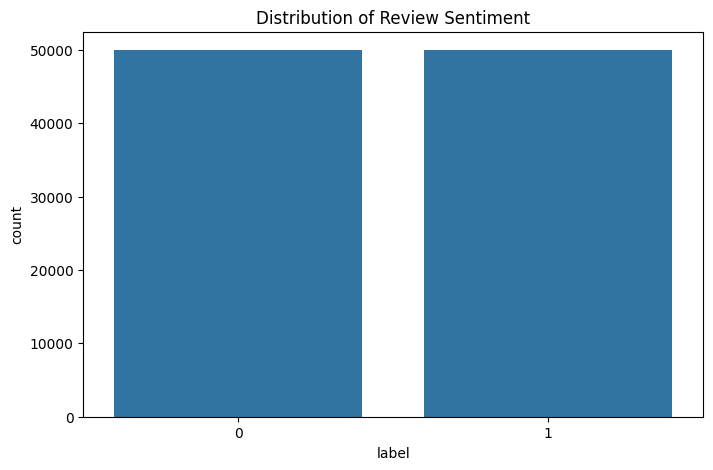

In [17]:
# Class distribution
print("\nLabel distribution:")
print(df_train['label'].value_counts())
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df_train)
plt.title('Distribution of Review Sentiment')
plt.show()

Polarity:
- 0 for negative
- 1 for positive

In [18]:
# Basic text statistics
df_train['text_length'] = df_train['text'].apply(len)
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))

print("\nText length statistics:")
print(df_train['text_length'].describe())
print("\nWord count statistics:")
print(df_train['word_count'].describe())


Text length statistics:
count    100000.000000
mean        430.311860
std         238.760973
min          99.000000
25%         229.000000
50%         380.000000
75%         595.000000
max        1014.000000
Name: text_length, dtype: float64

Word count statistics:
count    100000.000000
mean         78.412390
std          43.036738
min           5.000000
25%          42.000000
50%          70.000000
75%         108.000000
max         219.000000
Name: word_count, dtype: float64


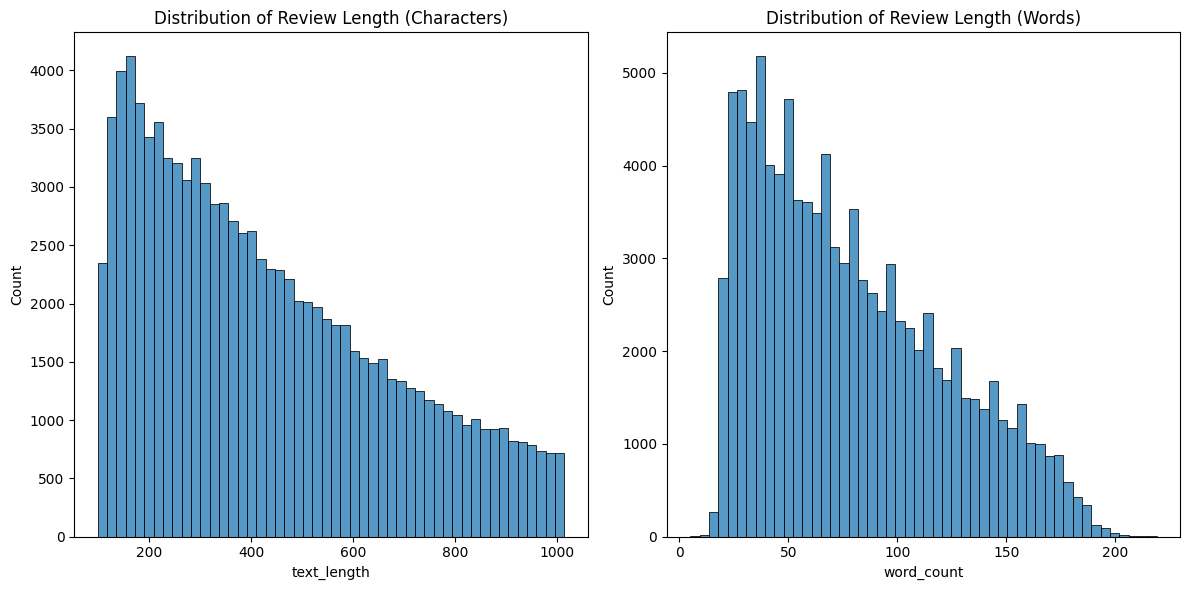

In [19]:
# Plot length distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_train['text_length'], bins=50)
plt.title('Distribution of Review Length (Characters)')
plt.subplot(1, 2, 2)
sns.histplot(df_train['word_count'], bins=50)
plt.title('Distribution of Review Length (Words)')
plt.tight_layout()
plt.show()

## Data Preprocessing

### Text Cleaning Functions

In [20]:
def clean_text(text):
    """
    Comprehensive text cleaning function
    """
    if isinstance(text, float):  # Handle NaN values
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove user mentions (like @user)
    text = re.sub(r'@\w+', '', text)
    
    # Replace product model numbers and specific identifiers
    text = re.sub(r'\b[a-zA-Z0-9]{10,}\b', ' product ', text)
    
    # Replace numbers with 'number'
    text = re.sub(r'\d+', ' number ', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def remove_stopwords(text):
    """
    Remove stopwords while preserving negation words
    """
    stop_words = set(stopwords.words('english'))
    # Keep negation words as they're important for sentiment
    negation_words = {'no', 'not', 'nor', 'neither', "don't", "doesn't", "didn't", "wasn't", "weren't", "haven't", "hasn't", "hadn't", "can't", "couldn't", "shouldn't", "won't", "wouldn't", "isn't", "aren't"}
    stop_words = stop_words - negation_words
    
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

def lemmatize_text(text):
    """
    Lemmatize text to reduce words to their base form
    """
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

# Optional function for stemming (often lemmatization is preferred for sentiment analysis)
def stem_text(text):
    """
    Stem words in text
    """
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

### Advanced Preprocessing Pipeline

Applying text cleaning...

Preprocessing results sample:

Original: Two little parents reading to their childmade her laugh and chant for joy.Mama emailed Amazon. coman...
Cleaned: two little parents reading to their childmade her laugh and chant for joymama emailed amazon comand ...
Cleaned (no stopwords): two little parents reading childmade laugh chant joymama emailed amazon comand sent morecheck five l...
Lemmatized: two little parent reading childmade laugh chant joymama emailed amazon comand sent morecheck five li...

Original: GIFTED AND TALENTED COMPOSERS LIKE YANNI ARE LIKE RAINBOWS, 'RARE & BEAUTIFUL'. THE FACT THAT HE CHO...
Cleaned: gifted and talented composers like yanni are like rainbows rare beautiful the fact that he chose to ...
Cleaned (no stopwords): gifted talented composers like yanni like rainbows rare beautiful fact chose share inner beauty prod...
Lemmatized: gifted talented composer like yanni like rainbow rare beautiful fact chose share inner beauty produc...

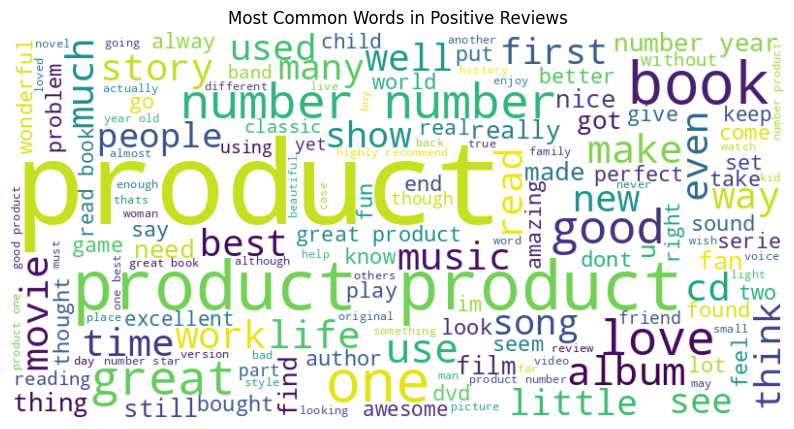

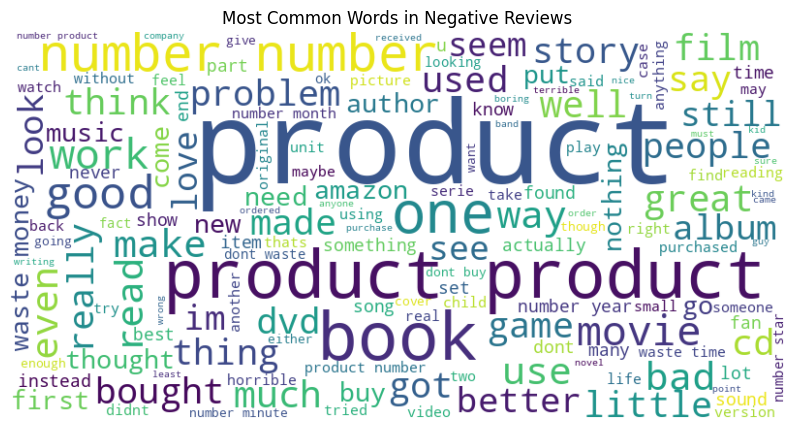

In [21]:
# Create a copy of the original dataframe to preserve original data
df_processed = df_train.copy()

# Apply cleaning functions
print("Applying text cleaning...")
df_processed['cleaned_text'] = df_processed['text'].apply(clean_text)
df_processed['cleaned_no_stop'] = df_processed['cleaned_text'].apply(remove_stopwords)
df_processed['lemmatized_text'] = df_processed['cleaned_no_stop'].apply(lemmatize_text)

# Check the results
print("\nPreprocessing results sample:")
for i in range(3):  # Show first 3 examples
    print(f"\nOriginal: {df_processed['text'].iloc[i][:100]}...")
    print(f"Cleaned: {df_processed['cleaned_text'].iloc[i][:100]}...")
    print(f"Cleaned (no stopwords): {df_processed['cleaned_no_stop'].iloc[i][:100]}...")
    print(f"Lemmatized: {df_processed['lemmatized_text'].iloc[i][:100]}...")

# Generate word clouds for each sentiment class
def generate_wordcloud(text_series, title):
    """Generate and display wordcloud"""
    all_text = ' '.join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(all_text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Assuming binary sentiment (e.g., positive=1, negative=0)
positive_reviews = df_processed[df_processed['label'] == 1]['lemmatized_text']
negative_reviews = df_processed[df_processed['label'] == 0]['lemmatized_text']

generate_wordcloud(positive_reviews, 'Most Common Words in Positive Reviews')
generate_wordcloud(negative_reviews, 'Most Common Words in Negative Reviews')

### Feature Engineering

In [22]:
# Text-based feature engineering
df_processed['text_length'] = df_processed['text'].apply(len)
df_processed['word_count'] = df_processed['text'].apply(lambda x: len(str(x).split()))
df_processed['avg_word_length'] = df_processed['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0)
df_processed['exclamation_count'] = df_processed['text'].apply(lambda x: x.count('!'))
df_processed['question_count'] = df_processed['text'].apply(lambda x: x.count('?'))
df_processed['uppercase_word_count'] = df_processed['text'].apply(lambda x: sum(1 for word in x.split() if word.isupper() and len(word) > 1))
df_processed['uppercase_ratio'] = df_processed['uppercase_word_count'] / (df_processed['word_count'] + 1)  # +1 to avoid division by zero

# Sentiment-specific features
def count_positive_words(text):
    """Count appearance of common positive words"""
    positive_words = ['good', 'great', 'excellent', 'amazing', 'wonderful', 'best', 'love', 'perfect', 'recommend', 'happy', 'awesome']
    return sum(1 for word in text.lower().split() if word in positive_words)

def count_negative_words(text):
    """Count appearance of common negative words"""
    negative_words = ['bad', 'poor', 'terrible', 'horrible', 'worst', 'waste', 'disappointed', 'disappointing', 'difficult', 'hate', 'problem', 'issue', 'fail']
    return sum(1 for word in text.lower().split() if word in negative_words)

df_processed['positive_word_count'] = df_processed['text'].apply(count_positive_words)
df_processed['negative_word_count'] = df_processed['text'].apply(count_negative_words)
df_processed['sentiment_word_ratio'] = (df_processed['positive_word_count'] + 1) / (df_processed['negative_word_count'] + 1)

# TF-IDF feature extraction (for n-grams)
print("Generating TF-IDF representations...")
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,  # Minimum document frequency
    max_df=0.8,  # Maximum document frequency
    ngram_range=(1, 2),  # Use unigrams and bigrams
    max_features=10000  # Limit vocabulary size
)
tfidf_features = tfidf_vectorizer.fit_transform(df_processed['lemmatized_text'])

# Show the most important TF-IDF features
feature_names = tfidf_vectorizer.get_feature_names_out()
print("\nTop TF-IDF features:")
for i, feature in enumerate(feature_names[:20]):
    print(f"{feature}")

Generating TF-IDF representations...

Top TF-IDF features:
aa
ab
abandoned
ability
able
able find
able get
able product
able put
able use
absent
absolute
absorb
absurd
abuse
abused
ac
academic
academy
accent


### Final Data Preparation and Saving

In [23]:
# Create final dataset with selected features
# Choose the preprocessing level you prefer (cleaned_text, cleaned_no_stop, or lemmatized_text)
final_df = df_processed[['label', 'lemmatized_text', 'text_length', 'word_count', 'avg_word_length',
                        'exclamation_count', 'question_count', 'uppercase_ratio',
                        'positive_word_count', 'negative_word_count', 'sentiment_word_ratio']]

# Save processed data
final_df.to_csv('data/final_df.csv', index=False)

# Save TF-IDF features for later use (optional)
import pickle
with open('tfidf_features.pkl', 'wb') as f:
    pickle.dump({'features': tfidf_features, 'vectorizer': tfidf_vectorizer}, f)

print("Preprocessing complete! Data saved to 'final_df.csv'")

# Show summary statistics of the engineered features
print("\nEngineered features summary:")
print(final_df.describe())

Preprocessing complete! Data saved to 'final_df.csv'

Engineered features summary:
               label    text_length     word_count  avg_word_length  \
count  100000.000000  100000.000000  100000.000000    100000.000000   
mean        0.500000     430.311860      78.412390         4.506840   
std         0.500003     238.760973      43.036738         0.474143   
min         0.000000      99.000000       5.000000         2.607143   
25%         0.000000     229.000000      42.000000         4.200000   
50%         0.500000     380.000000      70.000000         4.464286   
75%         1.000000     595.000000     108.000000         4.763158   
max         1.000000    1014.000000     219.000000        42.000000   

       exclamation_count  question_count  uppercase_ratio  \
count      100000.000000    100000.00000    100000.000000   
mean            0.881840         0.18257         0.020872   
std             2.520437         0.85835         0.087622   
min             0.000000         

## Modelling

In [ ]:
final_df=pd.read_csv('./data/final_df.csv')

## Evaluation

In [ ]:
df_test = pd.read_csv('./data/df_test.csv')

## pip freeze | grep -E "numpy|pandas|matplotlib|seaborn"Testing